In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST data
def get_data_loader(batch_size=128):
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

data_loader = get_data_loader()

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.54MB/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)  # Compress to latent_dim
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),  # Output values in [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Train Autoencoder
def train_autoencoder(model, dataloader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for imgs, _ in dataloader:
            imgs = imgs.view(imgs.size(0), -1).to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, imgs)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    return model

# Run everything
model = Autoencoder()
trained_model = train_autoencoder(model, data_loader, epochs=10)

Epoch [1/10], Loss: 0.0391
Epoch [2/10], Loss: 0.0284
Epoch [3/10], Loss: 0.0222
Epoch [4/10], Loss: 0.0223
Epoch [5/10], Loss: 0.0200
Epoch [6/10], Loss: 0.0170
Epoch [7/10], Loss: 0.0185
Epoch [8/10], Loss: 0.0153
Epoch [9/10], Loss: 0.0166
Epoch [10/10], Loss: 0.0156


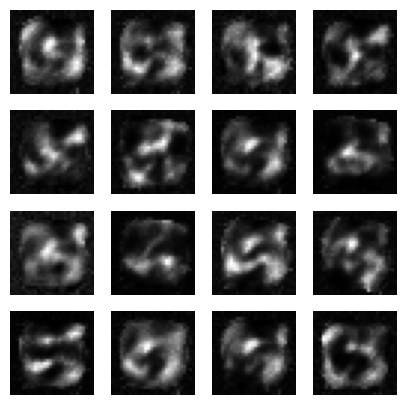

In [ ]:
# Generate random images from learned latent space
def generate_images(model, num_samples=16, latent_dim=16):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
        random_latent_vectors = torch.randn(num_samples, latent_dim).to(device)  # Sample from normal distribution
        generated_images = model.decoder(random_latent_vectors).cpu().numpy()

    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].reshape(28, 28), cmap="gray")
        ax.axis("off")
    plt.show()

generate_images(trained_model)

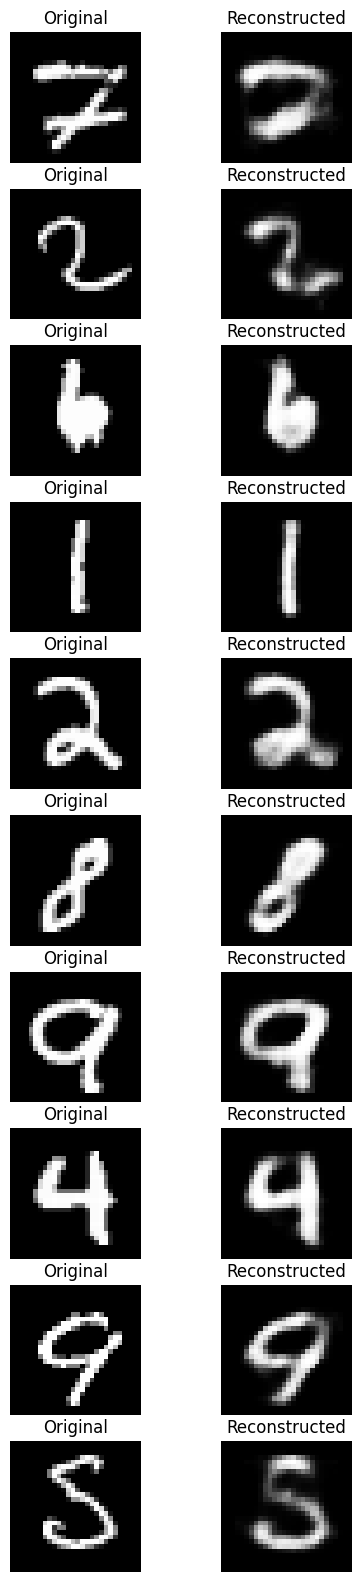

In [ ]:
import torch
import matplotlib.pyplot as plt

def evaluate_autoencoder_on_real_data(autoencoder, dataloader, num_samples=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder.to(device).eval()

    # Get a batch of real MNIST images
    images, _ = next(iter(dataloader))
    images = images[:num_samples].view(num_samples, -1).to(device)

    # Encode and decode the images
    with torch.no_grad():
        reconstructed_images = autoencoder(images).cpu().numpy()

    # Plot original and reconstructed images
    fig, axes = plt.subplots(num_samples, 2, figsize=(5, num_samples * 2))
    for i in range(num_samples):
        axes[i, 0].imshow(images[i].cpu().numpy().reshape(28, 28), cmap='gray')
        axes[i, 0].set_title("Original")
        axes[i, 1].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        axes[i, 1].set_title("Reconstructed")
        axes[i, 0].axis("off")
        axes[i, 1].axis("off")
    plt.show()

# Evaluate the trained autoencoder on real MNIST data
evaluate_autoencoder_on_real_data(trained_model, data_loader)

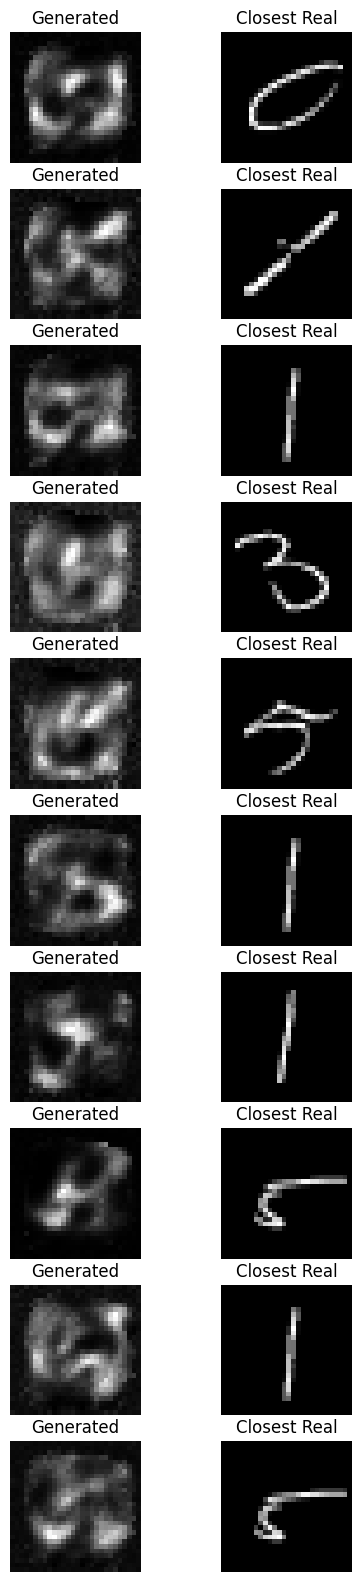

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def get_mnist_data():
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    images, _ = next(iter(dataloader))
    return images.view(len(dataset), -1).numpy()  # Flatten images

def mse_distance(img1, img2):
    return np.mean((img1 - img2) ** 2)

def find_closest_images(autoencoder, num_samples=10, latent_dim=16):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder.to(device).eval()

    # Get real MNIST images
    mnist_images = get_mnist_data()

    # Generate random images from latent space
    with torch.no_grad():
        random_latent_vectors = torch.randn(num_samples, latent_dim).to(device)
        generated_images = autoencoder.decoder(random_latent_vectors).cpu().numpy()

    # Find closest real image for each generated image
    closest_images = []
    for gen_img in generated_images:
        distances = [mse_distance(gen_img, real_img) for real_img in mnist_images]
        closest_idx = np.argmin(distances)
        closest_images.append(mnist_images[closest_idx])

    # Plot generated vs. closest real images
    fig, axes = plt.subplots(num_samples, 2, figsize=(5, num_samples * 2))
    for i in range(num_samples):
        axes[i, 0].imshow(generated_images[i].reshape(28, 28), cmap='gray')
        axes[i, 0].set_title("Generated")
        axes[i, 1].imshow(closest_images[i].reshape(28, 28), cmap='gray')
        axes[i, 1].set_title("Closest Real")
        axes[i, 0].axis("off")
        axes[i, 1].axis("off")
    plt.show()

# Example usage (Assumes `autoencoder` model is already trained)
find_closest_images(trained_model)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class VAE(nn.Module):
    def __init__(self, latent_dim=8):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.mu = nn.Linear(64, latent_dim)  # Mean
        self.logvar = nn.Linear(64, latent_dim)  # Log variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu, logvar = self.mu(encoded), self.logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar

# Loss function (Reconstruction + KL Divergence)
def vae_loss_function(reconstructed_x, x, mu, logvar):
    reconstruction_loss = nn.functional.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

# Training function
def train_vae(model, dataloader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for imgs, _ in dataloader:
            imgs = imgs.view(imgs.size(0), -1).to(device)
            optimizer.zero_grad()
            reconstructed, mu, logvar = model(imgs)
            loss = vae_loss_function(reconstructed, imgs, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")
    return model

# Train the VAE
vae_model = VAE()
vae_trained_model = train_vae(vae_model, data_loader, epochs=10)

Epoch [1/10], Loss: 3265045.0566
Epoch [2/10], Loss: 2500605.1860
Epoch [3/10], Loss: 2200297.9424
Epoch [4/10], Loss: 2082201.7168
Epoch [5/10], Loss: 2019067.5464
Epoch [6/10], Loss: 1976986.3528
Epoch [7/10], Loss: 1947660.5601
Epoch [8/10], Loss: 1923061.2407
Epoch [9/10], Loss: 1905799.5525
Epoch [10/10], Loss: 1888815.9841


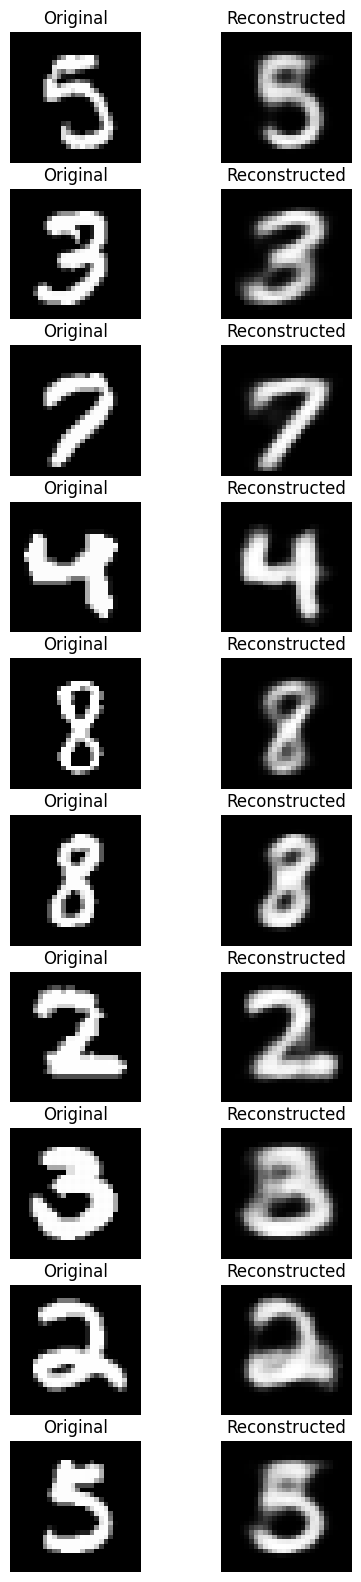

In [4]:
import torch
import matplotlib.pyplot as plt

def evaluate_vae_reconstruction(vae, dataloader, num_samples=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device).eval()

    # Get a batch of real MNIST images
    images, _ = next(iter(dataloader))
    images = images[:num_samples].view(num_samples, -1).to(device)

    # Encode and decode the images
    with torch.no_grad():
        reconstructed_images, _, _ = vae(images)
        reconstructed_images = reconstructed_images.cpu().numpy()

    # Plot original and reconstructed images
    fig, axes = plt.subplots(num_samples, 2, figsize=(5, num_samples * 2))
    for i in range(num_samples):
        axes[i, 0].imshow(images[i].cpu().numpy().reshape(28, 28), cmap='gray')
        axes[i, 0].set_title("Original")
        axes[i, 1].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        axes[i, 1].set_title("Reconstructed")
        axes[i, 0].axis("off")
        axes[i, 1].axis("off")
    plt.show()

# Evaluate VAE reconstruction
evaluate_vae_reconstruction(vae_trained_model, data_loader)

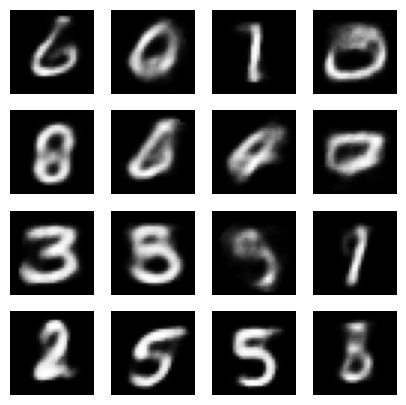

In [6]:
import torch
import matplotlib.pyplot as plt

def generate_images_vae(vae, num_samples=16, latent_dim=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device).eval()

    # Generate random latent vectors from a normal distribution
    with torch.no_grad():
        random_latent_vectors = torch.randn(num_samples, latent_dim).to(device)
        generated_images = vae.decoder(random_latent_vectors).cpu().numpy()

    # Plot generated images
    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        ax.axis("off")
    plt.show()

# Generate random samples from VAE
generate_images_vae(vae_trained_model)

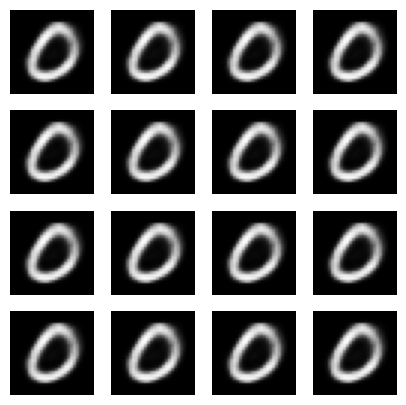

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

def get_digit_subset(dataloader, vae, digit=0, num_samples=1000):
    """Extracts all images of a specific digit from the dataset and encodes them using VAE."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device).eval()
    digit_images = []
    for images, labels in dataloader:
        mask = labels == digit
        digit_images.append(images[mask])
        if len(torch.cat(digit_images)) >= num_samples:
            break
    digit_images = torch.cat(digit_images)[:num_samples].to(device)  # Take subset and move to device

    # Encode the images using the VAE encoder
    with torch.no_grad():
        encoded_images = vae.encoder(digit_images.view(num_samples, -1))
        mu, logvar = vae.mu(encoded_images), vae.logvar(encoded_images)
        z = vae.reparameterize(mu, logvar)

    return z.cpu().numpy()  # Convert back to numpy

def sample_from_convex_hull(hull, num_samples=16):
    """Generates random points inside the convex hull."""
    points = hull.points
    dim = points.shape[1]
    rand_weights = np.random.dirichlet(alpha=np.ones(len(points)), size=num_samples)
    sampled_points = np.dot(rand_weights, points)  # Convex combination of hull points
    return sampled_points

def decode_and_plot_images(vae, sampled_points):
    """Decodes sampled latent points into images and plots them."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device).eval()
    sampled_tensors = torch.tensor(sampled_points, dtype=torch.float32).to(device)

    with torch.no_grad():
        generated_images = vae.decoder(sampled_tensors).cpu().numpy()

    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        ax.axis("off")
    plt.show()

# Extract only digit 0 from dataset and encode using VAE
zero_latent_vectors = get_digit_subset(data_loader, vae_trained_model, digit=0, num_samples=1000)

# Compute convex hull around encoded 0s
hull = ConvexHull(zero_latent_vectors)

# Sample random points inside convex hull
sampled_latent_points = sample_from_convex_hull(hull, num_samples=16)

# Decode and plot sampled points
decode_and_plot_images(vae_trained_model, sampled_latent_points)


In [5]:
hulls = []
for digit in range(10):
    digit_latent_vectors = get_digit_subset(data_loader, vae_trained_model, digit=digit, num_samples=1000)
    hull = ConvexHull(digit_latent_vectors)
    hulls.append(hull)

In [8]:
for i, hull in enumerate(hulls):
  print(f"Digit {i}:")
  print(f"  Area: {hull.area}")
  print(f"  Hull volume: {hull.volume}")


Digit 0:
  Area: 7459.852062994069
  Hull volume: 1642.719829877511
Digit 1:
  Area: 3662.1046304091155
  Hull volume: 715.2690027553779
Digit 2:
  Area: 6637.490232241585
  Hull volume: 1359.4767135811512
Digit 3:
  Area: 7744.585517022822
  Hull volume: 1769.8691074840838
Digit 4:
  Area: 5400.665904550975
  Hull volume: 1132.6703322539802
Digit 5:
  Area: 6129.849017605641
  Hull volume: 1277.5871845890015
Digit 6:
  Area: 4211.760113325148
  Hull volume: 843.0219190108292
Digit 7:
  Area: 8491.232538761768
  Hull volume: 1972.3290001380055
Digit 8:
  Area: 5738.7568038266945
  Hull volume: 1236.7937137331144
Digit 9:
  Area: 7155.7077846097345
  Hull volume: 1561.8395045694153


The facets of the hull are NOT the corners that form the convex hull nor the edges between adjacent corners creating the convex hull. if you imagine a 3d cube, the facets are the faces created by the vertices and edges. they are an indirect result of the convex hull that partitions inside and outside.

In [13]:
# prompt: for each hull find the ordering of hulls close to it

import numpy as np
def find_closest_hulls(hulls, target_hull_index, num_closest=5):
  """
  Finds the ordering of hulls closest to the target hull.

  Args:
    hulls: A list of ConvexHull objects.
    target_hull_index: The index of the target hull in the list.
    num_closest: The number of closest hulls to find.

  Returns:
    A list of tuples (hull_index, distance) sorted by distance,
    representing the closest hulls to the target hull.
  """
  target_hull = hulls[target_hull_index]
  distances = []
  for i, hull in enumerate(hulls):
    if i != target_hull_index:
      # Calculate distance between the centroids of the hulls
      # (you can use other metrics as needed)
      target_centroid = np.mean(target_hull.points, axis=0)
      hull_centroid = np.mean(hull.points, axis=0)
      distance = np.linalg.norm(target_centroid - hull_centroid)
      distances.append((i, distance))

  distances.sort(key=lambda x: x[1])  # Sort by distance
  return distances[:num_closest]

# Example usage
for i in range(len(hulls)):
  closest_hulls = find_closest_hulls(hulls, i, num_closest=9)
  print(f"Digit {i} closest hulls:")
  for hull_index, distance in closest_hulls:
    print(f"  - Digit {hull_index}, distance: {distance:.2f}")



Digit 0 closest hulls:
  - Digit 5, distance: 1.54
  - Digit 6, distance: 2.11
  - Digit 8, distance: 2.31
  - Digit 9, distance: 2.36
  - Digit 3, distance: 2.49
  - Digit 2, distance: 2.61
  - Digit 4, distance: 2.61
  - Digit 7, distance: 2.85
  - Digit 1, distance: 3.57
Digit 1 closest hulls:
  - Digit 2, distance: 2.42
  - Digit 5, distance: 2.51
  - Digit 8, distance: 2.52
  - Digit 3, distance: 2.58
  - Digit 6, distance: 2.67
  - Digit 9, distance: 2.72
  - Digit 7, distance: 2.73
  - Digit 4, distance: 2.78
  - Digit 0, distance: 3.57
Digit 2 closest hulls:
  - Digit 8, distance: 2.07
  - Digit 3, distance: 2.31
  - Digit 6, distance: 2.33
  - Digit 1, distance: 2.42
  - Digit 4, distance: 2.59
  - Digit 0, distance: 2.61
  - Digit 5, distance: 2.61
  - Digit 9, distance: 2.75
  - Digit 7, distance: 2.84
Digit 3 closest hulls:
  - Digit 5, distance: 1.62
  - Digit 8, distance: 1.95
  - Digit 2, distance: 2.31
  - Digit 0, distance: 2.49
  - Digit 1, distance: 2.58
  - Digit 9,

In [16]:
# prompt: make kd trees from vertices of all hulls

import numpy as np
from scipy.spatial import KDTree

# Assuming you have a list of hulls called 'hulls'
kd_trees = [KDTree(hull.points) for hull in hulls]

In [20]:
# prompt: for each pair of kd trees find the closest point between each tree

import numpy as np
def find_closest_points_between_kdtrees(kd_trees):
  """
  Finds the closest point between each pair of KD trees.

  Args:
    kd_trees: A list of KDTree objects.

  Returns:
    A list of tuples (tree1_index, tree2_index, closest_point_tree1, closest_point_tree2, distance).
  """
  closest_points = []
  for i in range(len(kd_trees)):
    for j in range(i + 1, len(kd_trees)):
      tree1 = kd_trees[i]
      tree2 = kd_trees[j]

      # Find the closest point between the two trees
      distances, indices = tree1.query(tree2.data, k=1)  # Query for the nearest neighbor in tree2 for each point in tree1
      min_distance = np.min(distances)
      min_index = np.argmin(distances)

      closest_point_tree1 = tree1.data[indices[min_index]]
      closest_point_tree2 = tree2.data[min_index]

      closest_points.append((i, j, closest_point_tree1, closest_point_tree2, min_distance))

  return closest_points

# Assuming you have a list of KD trees called 'kd_trees'
closest_points_between_trees = find_closest_points_between_kdtrees(kd_trees)

# Print the closest points between each pair of trees
for tree1_index, tree2_index, closest_point_tree1, closest_point_tree2, distance in closest_points_between_trees:
    print(f"Closest points between trees {tree1_index} and {tree2_index}:")
    print(f"  - Tree {tree1_index}: {closest_point_tree1}")
    print(f"  - Tree {tree2_index}: {closest_point_tree2}")
    print(f"  - Distance: {distance:.2f}")


Closest points between trees 0 and 1:
  - Tree 0: [-0.10075909 -0.29401267 -0.38411799 -0.10708337 -1.28601289 -0.5455575
  1.0830828   0.11355466]
  - Tree 1: [ 0.1625475  -0.56181264 -0.66314256  0.08724523 -1.39346719 -0.48308471
  1.13985109  0.29507121]
  - Distance: 0.56
Closest points between trees 0 and 2:
  - Tree 0: [ 0.33504993 -0.04932807  0.24081109 -0.18951841  0.48897606 -1.84207058
 -0.89386159 -0.1565458 ]
  - Tree 2: [ 1.24512970e-01 -2.27044642e-01  5.03107548e-01 -1.16229296e-01
  3.47574115e-01 -1.47686350e+00 -1.06715322e+00  1.25810504e-03]
  - Distance: 0.60
Closest points between trees 0 and 3:
  - Tree 0: [-0.08373721 -0.22691101  0.33194387 -0.04470895 -0.62842792 -0.74654835
 -0.66974741 -0.07908022]
  - Tree 3: [ 0.24515554 -0.23488224 -0.0976094   0.32867163 -0.94329941 -0.51245439
 -0.2677176   0.10713466]
  - Distance: 0.88
Closest points between trees 0 and 4:
  - Tree 0: [-0.14731772  0.08174324  0.50410104  0.26256025  0.46401045 -0.69477999
 -0.11113

In [1]:
from google.colab import _message

# Get notebook JSON data
nb = _message.blocking_request('get_ipynb')['ipynb']

# Extract and print code from all cells
for i, cell in enumerate(nb['cells']):
    if cell['cell_type'] == 'code':
        print(f"### CELL {i} ###")
        print(''.join(cell['source']))
        print("\n--- CELL SEPARATOR ---\n")

### CELL 0 ###
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST data
def get_data_loader(batch_size=128):
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

data_loader = get_data_loader()

--- CELL SEPARATOR ---

### CELL 1 ###
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28